#### 이 문서는 초보가 제작하였으므로, 틀린 부분이 있을 지도 모릅니다.

### References
- http://sanghyukchun.github.io/75/
- https://deeplearning4j.org/kr/restrictedboltzmannmachine (https://deeplearning4j.org/restrictedboltzmannmachine)
- http://parkcu.com/blog/markov-chain-monte-carlo-and-gibbs-sampling/
- http://gorayni.blogspot.kr/2013/08/gibbs-sampling.html
- https://ko.wikipedia.org/wiki/기브스_표집
- http://www.whydsp.org/283
- http://solarisailab.com/archives/113
- https://wikidocs.net/3413
- http://sanghyukchun.github.io/74/
- http://www.ericlwilkinson.com/blog/2014/11/19/deep-learning-sparse-autoencoders

### source code
- https://github.com/sjchoi86/tensorflow-101/blob/master/notebooks/dae_mnist_dropout.ipynb

# RBM (Restricted Boltzmann Machines)

### RBM
- hidden layers: 1
    - deep neural network 아님.
- v: visible layer, h: hidden layer
- restricted: 같은 레이어의 노드끼리 연결되어 있지 않음.
- symmetrical: 학습 방향이 양방향.

<img src="img/rbm.png" width="300">
- propagation: p(a|x; w)
<img src="img/multiple_inputs_RBM.png">
- back propagation: p(x|a; w)
<img src="img/reconstruction_RBM.png">
- p(a, x)
    - 입력(x)과 출력(a)의 확률분포를 비슷하게 만듬.
    - 따라서, 다른 신경망에서 초기값으로 사용하면 좋음.

### KL Divergence
- Kullback Leibler Divergence
- 두 확률분포의 차이를 계산하는데 사용하는 함수
    - 정보 엔트로피의 차이를 이용
<img src="img/kl_divergence.jpg">
<img src="img/kl_divergence2.jpg">

### DBN (Deep Belief Network)

- multiple layers with RBM
- Unsupervised Learning
- 입력데이타에 의해, 초기화가 잘 된 W, b를 가진 신경망
- Contrastive Divergence 방식으로 학습.
<img src="img/dbn.png" width="300">
<img src="img/dbn2.png">

### Contrastive divergence
- Gibbs Sampling 을 converge 할 때까지가 아니라, 한번만 수행하여 gradient 의 approximate 한 값을 구함.

### Gibbs Sampling
- Metropolis-Hastings algorithm 의 특별한 경우
- 두개 이상의 확률 변수의 결합 확률 분포로부터 일련의 표본을 생성하는 확률적 알고리즘
- 올바른 근사를 위해 많은 표본이 필요하다.
- 중간 상태의 표본이 적을 경우, 잘 표집되지 않을 수 있다.
<img src="img/gibbs.png">
<img src="img/gibbs_demo.gif">

# Auto-Encoder
- 간단한 auto-encoder 는 PCA 와 유사함.
<img src="img/autoencoder.png">
- Output Layer의 노드의 개수가 Input Layer의 노드의 개수와 같다.

### Stacked Auto-Encoder
- DBN 이용
<img src="img/stackedAE.png">

### Sparse Auto-Encoder
- hidden node 의 개수가 visible node 보다 큰 경우.
<img src="img/sparseAE.png">


### K-Sparse Auto-Encoder
- CNN 과 비슷한 느낌 (by bage)
- k highest activations in z and zeros out the rest.
- 1000 hidden units
<img src="img/k_sparseAE_mnist.png">

# Denosing Auto-Encoder
- 데이터에 Noise 가 추가되었을 때, 이러한 Noise를 제거하여 원래의 데이터를 Extraction하는 모델
<img src="img/denoisingAE.png">

### Stacked Denosing Auto-Encoder
- 
<img src="img/stacked-denoisingAE.png">


***

# DAE for MNIST
- DAE = Denoising Auto-Encoder
- https://github.com/sjchoi86/tensorflow-101/blob/master/notebooks/dae_mnist_dropout.ipynb

### Prepare MNIST DATA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

from bage_utils.base_util import is_server
from nlp4kor.config import MNIST_DATA_DIR, MNIST_DAE_MODEL_DIR, log

mnist_data = MNIST_DATA_DIR # input
mnist_model = MNIST_DAE_MODEL_DIR # output

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(mnist_data, one_hot=True) # read MNIST data

Extracting /home/bage/workspace/nlp4kor-mnist/data/train-images-idx3-ubyte.gz
Extracting /home/bage/workspace/nlp4kor-mnist/data/train-labels-idx1-ubyte.gz
Extracting /home/bage/workspace/nlp4kor-mnist/data/t10k-images-idx3-ubyte.gz
Extracting /home/bage/workspace/nlp4kor-mnist/data/t10k-labels-idx1-ubyte.gz


### Noise Function

### Salt and pepper noise
https://ko.wikipedia.org/wiki/점잡음
<img src="https://upload.wikimedia.org/wikipedia/commons/f/f4/Noise_salt_and_pepper.png">

https://en.wikipedia.org/wiki/Gaussian_noise
<img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/512x512-No-Noise.jpg">
<img src="https://upload.wikimedia.org/wikipedia/commons/d/d2/512x512-Gaussian-Noise.jpg">

In [2]:
def noise_images(images, noise_type='gaussian', noise_rate=0.2):
    if noise_type == 'gaussian':
        return images + noise_rate * np.random.randn(images.shape[0], images.shape[1])
    elif noise_type == 'salt_pepper':
        for row in range(len(images)):
            noiseidx = np.random.randint(images.shape[1], size=int(images.shape[1] * noise_rate))
            _images = np.copy(images)
            _images[:, noiseidx] = 1-images[:, noiseidx]  # 색상 반전이지만, salt and pepper와 효과는 동일.
        return _images
    else:
        return images

### Create Graph

In [3]:
device2use = '/gpu:0' if is_server() else '/cpu:0'

model_file = os.path.join(MNIST_DAE_MODEL_DIR, 'dae_mnist_model/model')  # .%s' % max_sentences
log.info('model_file: %s' % model_file)

model_dir = os.path.dirname(model_file)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

mnist = input_data.read_data_sets(mnist_data, one_hot=True)
assert (mnist.train.images.shape[1] == mnist.test.images.shape[1])
n_train = mnist.train.images.shape[0]
n_input_dim = mnist.train.images.shape[1]  # MNIST data input (img shape: 28*28)
n_output_dim = n_input_dim  # MNIST data input (img shape: 28*28)
n_hidden_1 = 256  # 1st layer num features
n_hidden_2 = 256  # 2nd layer num features

log.info('n_input_dim: %s' % n_input_dim)
log.info('n_output_dim: %s' % n_output_dim)
log.info('n_hidden_1: %s' % n_hidden_1)
log.info('n_hidden_2: %s' % n_hidden_2)
log.info('n_train: %s' % n_train)

def denoising_autoencoder(_X, _weights, _biases, _keep_prob):
    layer_1 = tf.nn.sigmoid(tf.matmul(_X, _weights['h1']) + _biases['b1'])
    layer_1out = tf.nn.dropout(layer_1, _keep_prob)
    layer_2 = tf.nn.sigmoid(tf.matmul(layer_1out, _weights['h2']) +  _biases['b2'])
    layer_2out = tf.nn.dropout(layer_2, _keep_prob)
    return tf.nn.sigmoid(tf.matmul(layer_2out, _weights['out']) + _biases['out'])

with tf.device(device2use):
    log.info('create graph...')

    # tf Graph input
    x = tf.placeholder('float', [None, n_input_dim])
    y = tf.placeholder('float', [None, n_output_dim])
    dropout_keep_prob = tf.placeholder('float')

    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input_dim, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, n_output_dim]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_output_dim]))
    }

    out = denoising_autoencoder(x, weights, biases, dropout_keep_prob)  # model
    cost = tf.reduce_mean(tf.pow(out - y, 2))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)
    init = tf.global_variables_initializer()
    log.info('out: %s' % out)
    log.info('cost: %s' % cost)
    log.info('optimizer: %s' % optimizer)
    log.info('create graph OK.')
    log.info('')

with tf.device('/cpu:0'):
    saver = tf.train.Saver(max_to_keep=3)  # => cpu

model_file: /home/bage/workspace/nlp4kor-mnist/models/dae/dae_mnist_model/model
Extracting /home/bage/workspace/nlp4kor-mnist/data/train-images-idx3-ubyte.gz
Extracting /home/bage/workspace/nlp4kor-mnist/data/train-labels-idx1-ubyte.gz
Extracting /home/bage/workspace/nlp4kor-mnist/data/t10k-images-idx3-ubyte.gz
Extracting /home/bage/workspace/nlp4kor-mnist/data/t10k-labels-idx1-ubyte.gz
n_input_dim: 784
n_output_dim: 784
n_hidden_1: 256
n_hidden_2: 256
n_train: 55000
create graph...
out: Tensor("Sigmoid_2:0", shape=(?, 784), dtype=float32, device=/device:CPU:0)
cost: Tensor("Mean:0", shape=(), dtype=float32, device=/device:CPU:0)
optimizer: name: "Adam"
op: "NoOp"
input: "^Adam/update_Variable/ApplyAdam"
input: "^Adam/update_Variable_1/ApplyAdam"
input: "^Adam/update_Variable_2/ApplyAdam"
input: "^Adam/update_Variable_3/ApplyAdam"
input: "^Adam/update_Variable_4/ApplyAdam"
input: "^Adam/update_Variable_5/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"
device: "/device:CPU:0"



### Learning

In [4]:
image_shape = (28, 28) # image resolution
plot_step = 5  # display plots.
n_validation = 100 # validation size

training_epochs = 30 # total training epoch
batch_size = 100  # training mini batch size
dropout_keep = 0.5 # keep rate for dropout
noise_type, noise_rate = 'salt_pepper', 0.1 # 원본 소스와 다르게 salt and pepper 방식으로 학습함. (one hot vector의 noise에 적합하므로.)

log.info('image_shape: %s' % str(image_shape))
log.info('training_epochs: %s' % training_epochs)
log.info('batch_size: %s' % batch_size)
log.info('dropout_keep: %s' % dropout_keep)
log.info('noise_type: %s, noise_rate: %s' % (noise_type, noise_rate))

image_shape: (28, 28)
training_epochs: 30
batch_size: 100
dropout_keep: 0.5
noise_type: salt_pepper, noise_rate: 0.1


learning...
Epoch:   0/ 30 cost: 0.0002


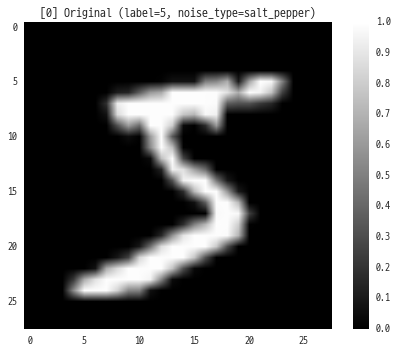

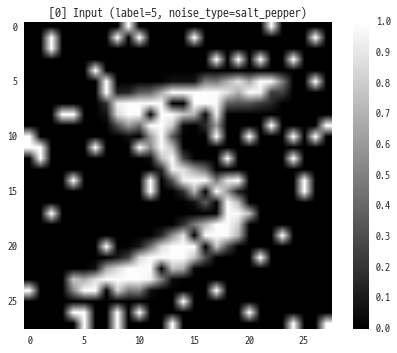

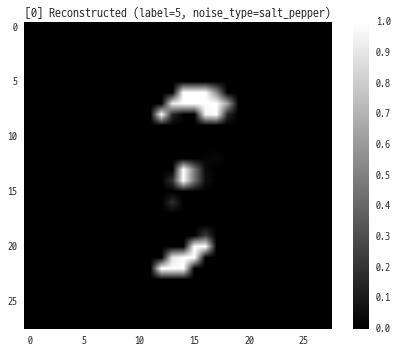

Epoch:   1/ 30 cost: 0.0001


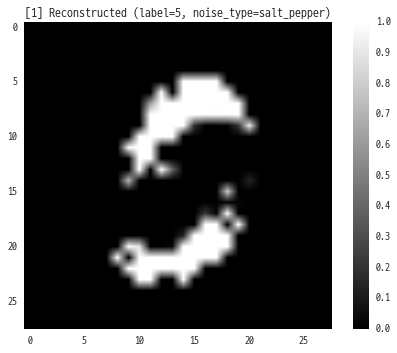

Epoch:   2/ 30 cost: 0.0001


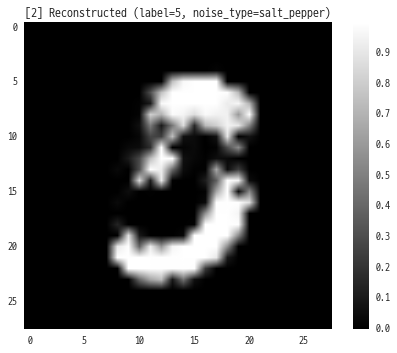

Epoch:   3/ 30 cost: 0.0001


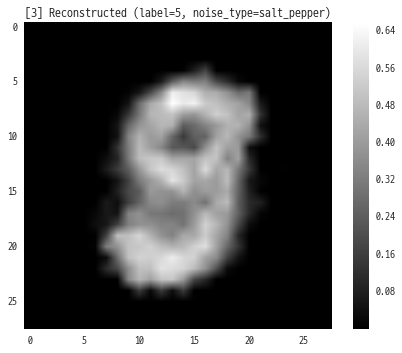

Epoch:   4/ 30 cost: 0.0001


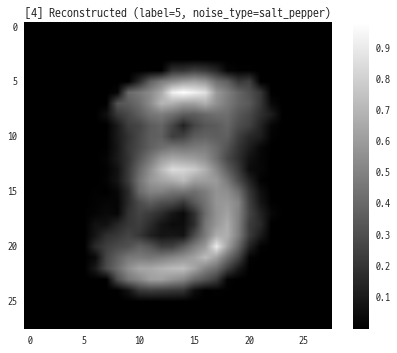

Epoch:   5/ 30 cost: 0.0001


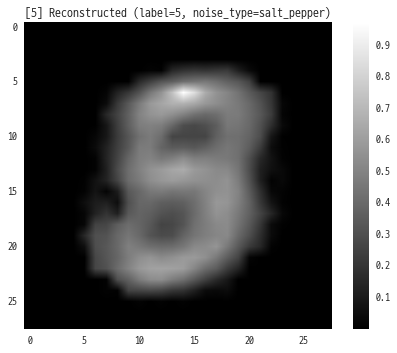

Epoch:   6/ 30 cost: 0.0001


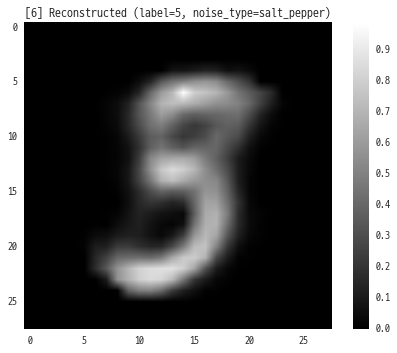

Epoch:   7/ 30 cost: 0.0001


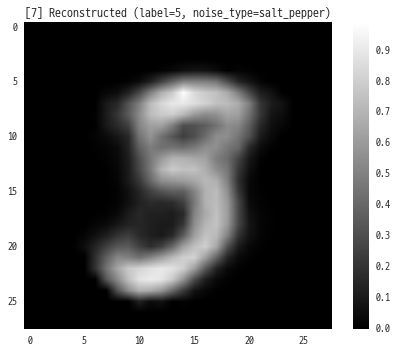

Epoch:   8/ 30 cost: 0.0001


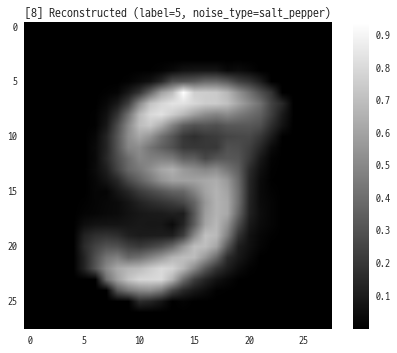

Epoch:   9/ 30 cost: 0.0000


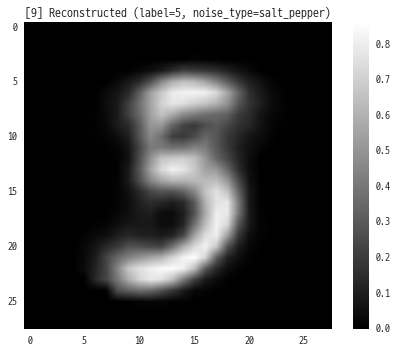

Epoch:  10/ 30 cost: 0.0000


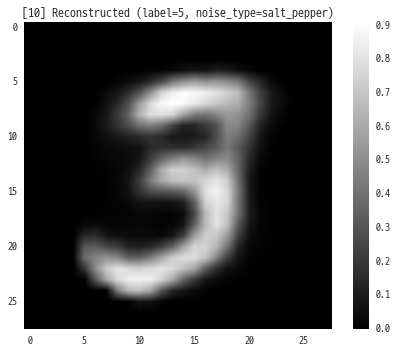

Epoch:  11/ 30
Epoch:  12/ 30
Epoch:  13/ 30
Epoch:  14/ 30
Epoch:  15/ 30 cost: 0.0000


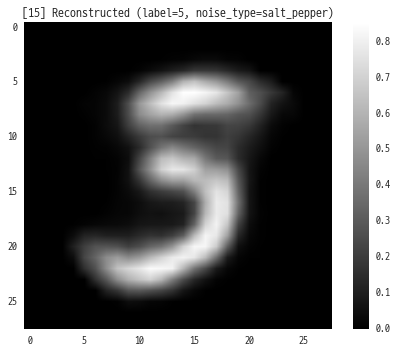

Epoch:  16/ 30
Epoch:  17/ 30
Epoch:  18/ 30
Epoch:  19/ 30
Epoch:  20/ 30 cost: 0.0000


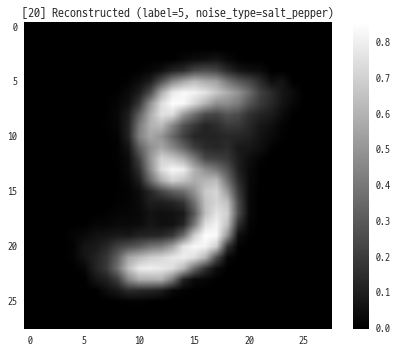

Epoch:  21/ 30
Epoch:  22/ 30
Epoch:  23/ 30
Epoch:  24/ 30
Epoch:  25/ 30 cost: 0.0000


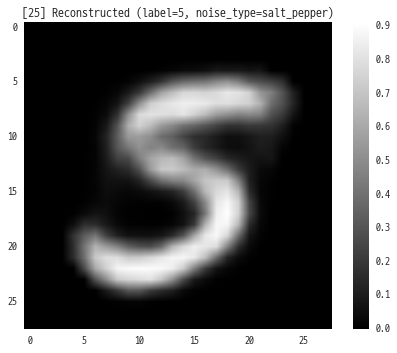

Epoch:  26/ 30
Epoch:  27/ 30
Epoch:  28/ 30
Epoch:  29/ 30 cost: 0.0000


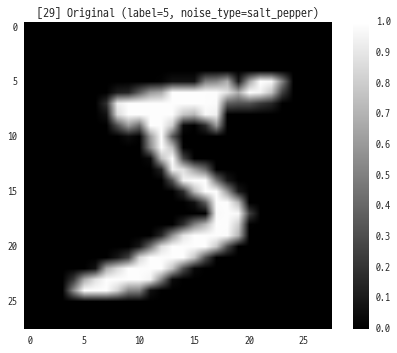

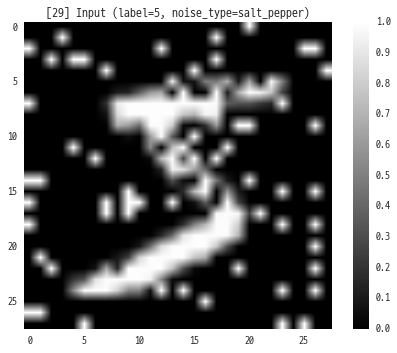

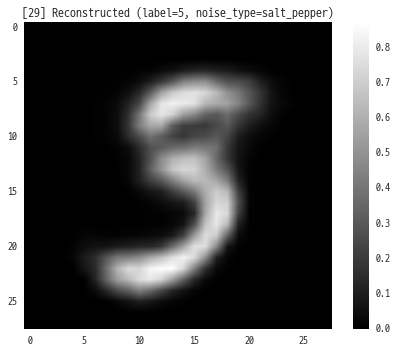

learning OK.


In [5]:
# with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess: # original source code
with tf.Session() as sess:
    sess.run(init)
    
    if True: # for demo
#     if not os.path.exists(model_file + '.index') or not os.path.exists(model_file + '.meta'):
        log.info('learning...')
        for epoch in range(training_epochs):
            avg_cost = 0.
            num_batch = int(mnist.train.images.shape[0] / batch_size)
            for i in range(num_batch):
                randidx = np.random.randint(n_train, size=batch_size)
                batch_xs = mnist.train.images[randidx, :]
                
                batch_xs_noisy = noise_images(batch_xs, 'salt_pepper', noise_rate=noise_rate)

                feed1 = {x: batch_xs_noisy, y: batch_xs, dropout_keep_prob: dropout_keep}  # dropout_keep_prob=0.5 for learning
                sess.run(optimizer, feed_dict=feed1)

            if epoch < 10 or epoch % plot_step == 0 or epoch == training_epochs - 1:
                batch_validation = mnist.validation.images[:n_validation, :]
                labels  = np.argmax(mnist.validation.labels[:n_validation, :], axis=1)
                
                batch_validation_noised = noise_images(batch_validation, 'salt_pepper', noise_rate=noise_rate)
                feed2 = {x: batch_validation_noised, y: batch_validation, dropout_keep_prob: 1.}  # dropout_keep_prob=1 for calculate cost
                avg_cost += sess.run(cost, feed_dict=feed2) / num_batch
                log.info('Epoch: %3d/%3d cost: %.4f' % (epoch, training_epochs, avg_cost))
                
                image_original = batch_validation[[0], :]
                label = labels[0]
                image_noised = noise_images(image_original, 'salt_pepper', noise_rate=noise_rate)
                
                output = sess.run(out, feed_dict={x: image_noised, dropout_keep_prob: 1.})
                image_output = np.reshape(output, image_shape)
                if epoch == 0 or epoch == training_epochs - 1:
                    plt.title("[%s] Original (label=%s, noise_type=%s)" % (epoch, label, noise_type))
                    plt.imshow(np.reshape(image_original, image_shape), cmap=plt.get_cmap('gray'))
                    plt.colorbar()
                    plt.grid(False)
                    plt.show()
                    
                    plt.title("[%s] Input (label=%s, noise_type=%s)" % (epoch, label, noise_type))
                    plt.imshow(np.reshape(image_noised, (28, 28)), cmap=plt.get_cmap('gray'))
                    plt.colorbar()
                    plt.grid(False)
                    plt.show()
                
                plt.title("[%s] Reconstructed (label=%s, noise_type=%s)" % (epoch, label, noise_type))
                plt.imshow(image_output, cmap=plt.get_cmap('gray'))
                plt.colorbar()
                plt.grid(False)
                plt.show()
            else:
                log.info('Epoch: %3d/%3d' % (epoch, training_epochs))
                
        saver.save(sess, model_file)  # , global_step=epoch)
        log.info('learning OK.')

## TEST
- salt and pepper로 학습한 모델에 대해서, salt and pepper noise 및 gaussian noise 방식 모두 테스트함.
- DAE는 gaussian noise 에 대해서도 원형으로 복원하는 능력을 가짐. (즉, 다른 노이즈 방식에도 학습된 모델을 사용할 수 있음.)

restore...
INFO:tensorflow:Restoring parameters from /home/bage/workspace/nlp4kor-mnist/models/dae/dae_mnist_model/model
Restoring parameters from /home/bage/workspace/nlp4kor-mnist/models/dae/dae_mnist_model/model
restore OK.
randidx: [19709]
labels: [7]



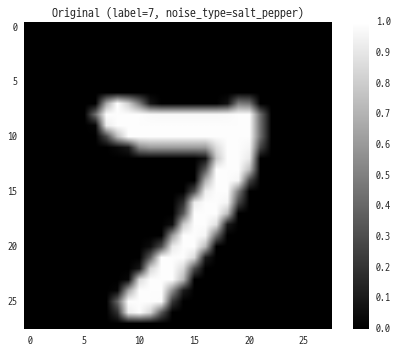

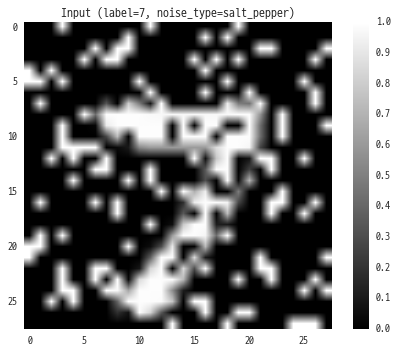

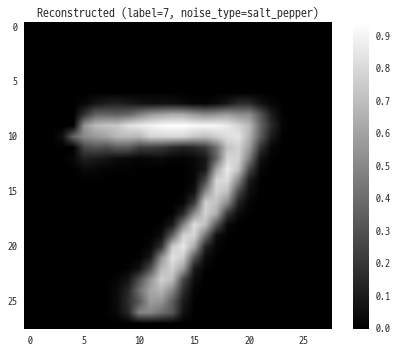

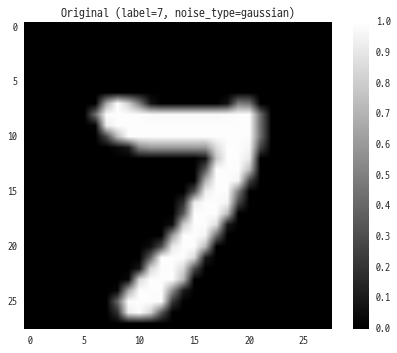

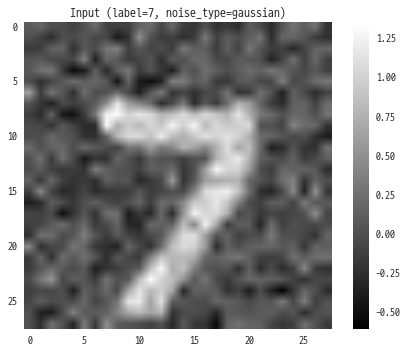

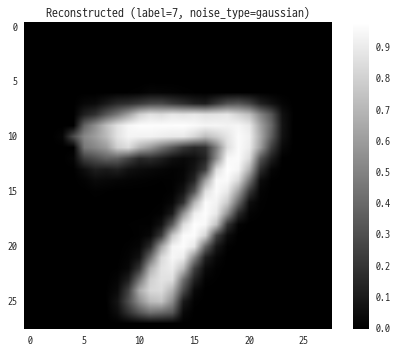

In [6]:
with tf.Session() as sess:
    sess.run(init)
    log.info('restore...')
    saver.restore(sess, model_file)
    log.info('restore OK.')
    
    randidx   = np.random.randint(n_train, size=1)  # 랜덤 선택할 이미지의 index
    orgvec    = mnist.train.images[randidx, :]  # 여러 개의 원본 이미지 중에서 랜덤 선택
    labels     = np.argmax(mnist.train.labels[randidx, :], axis=1) # 랜덤 선택한 이미지의 라벨 (0~9)
    log.info('randidx: %s' % randidx)
    log.info('labels: %s' % labels)
    for noise_type in ['salt_pepper', 'gaussian']:
        print('')
        noisyvec = noise_images(orgvec, noise_type=noise_type)
        images_output   = sess.run(out, feed_dict={x: noisyvec, dropout_keep_prob: 1})
        for i in range(orgvec.shape[0]):
            label = labels[i]
            
            plt.title("Original (label=%s, noise_type=%s)" % (label, noise_type))
            plt.imshow(np.reshape(orgvec[i], (28, 28)), cmap=plt.get_cmap('gray'))
            plt.grid(False)
            plt.colorbar()
            plt.show()

            plt.title("Input (label=%s, noise_type=%s)" % (label, noise_type))
            plt.imshow(np.reshape(noisyvec[i], (28, 28)), cmap=plt.get_cmap('gray'))
            plt.grid(False)
            plt.colorbar()
            plt.show()

            plt.title("Reconstructed (label=%s, noise_type=%s)" % (label, noise_type))
            plt.imshow(np.reshape(images_output[i], (28, 28)), cmap=plt.get_cmap('gray'))
            plt.grid(False)
            plt.colorbar()
            plt.show()


# Visualize Filter 

INFO:tensorflow:Restoring parameters from /home/bage/workspace/nlp4kor-mnist/models/dae/dae_mnist_model/model
Restoring parameters from /home/bage/workspace/nlp4kor-mnist/models/dae/dae_mnist_model/model
X: (256, 784) float32
img_shape: (28, 28)
tile_shpe: (10, 10)


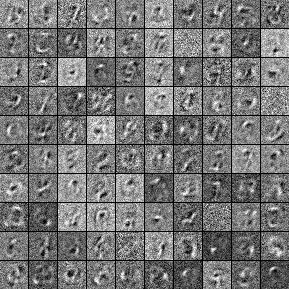

In [7]:
from PIL import Image

def scale_to_unit_interval(ndar, eps=1e-8):
    """ Scales all values in the ndarray ndar to be between 0 and 1 """
    ndar = ndar.copy()
    ndar =  (ndar - ndar.min()) / (ndar.max() - ndar.min() + eps)
    return ndar

def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True):
    """
    X: weight matrix
    img_shape: one image size. e.g. (28, 28) for MNIST
    tile_shape: number of images in crosswise, lengthwise
    tile_spacing: border between images.
    scale_rows_to_unit_interval: scale to 0~1
    output_pixel_vals: True=0~255(int), False=0.0~1.0(float)
    """
    assert len(img_shape) == 2
    assert len(tile_shape) == 2
    assert len(tile_spacing) == 2
    out_shape = [(ishp + tsp) * tshp - tsp for ishp, tshp, tsp
                      in zip(img_shape, tile_shape, tile_spacing)]

    print('X:', X.shape, X.dtype)
    print('img_shape:' , img_shape)
    print('tile_shpe:', tile_shape)
    # if we are dealing with only one channel
    H, W = img_shape
    Hs, Ws = tile_spacing

    # generate a matrix to store the output
    out_array = np.zeros(out_shape, dtype='uint8' if output_pixel_vals else X.dtype)
    for tile_row in range(tile_shape[0]):
        for tile_col in range(tile_shape[1]):
            if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                if scale_rows_to_unit_interval: # scale to 0~1
                    # if we should scale values to be between 0 and 1 do this by calling the `scale_to_unit_interval` function
                    this_img = scale_to_unit_interval(X[tile_row * tile_shape[1] + tile_col].reshape(img_shape))
                else:
                    this_img = X[tile_row * tile_shape[1] + tile_col].reshape(img_shape)
                # add the slice to the corresponding position in the output array
                out_array[
                    tile_row * (H+Hs): tile_row * (H + Hs) + H,
                    tile_col * (W+Ws): tile_col * (W + Ws) + W
                    ] = this_img * (255 if output_pixel_vals else 1)
    return out_array

# Visualize filter
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, model_file)
    
    w1 = sess.run(weights["h1"])
    image = Image.fromarray(tile_raster_images(
            X = w1.T,
            img_shape=(28, 28), # 이미지 1개 크기
            tile_shape=(10, 10), # 타일 개수 (가로 * 세로)
            tile_spacing=(1, 1)))
image

INFO:tensorflow:Restoring parameters from /home/bage/workspace/nlp4kor-mnist/models/dae/dae_mnist_model/model
Restoring parameters from /home/bage/workspace/nlp4kor-mnist/models/dae/dae_mnist_model/model
X: (256, 784) float32
img_shape: (28, 28)
tile_shpe: (10, 10)


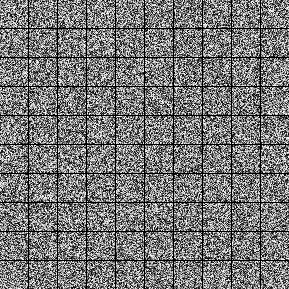

In [8]:
# Visualize filter
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, model_file)
    
    w1 = sess.run(weights["h1"])
    image2 = Image.fromarray(tile_raster_images(
            X = w1.T,
            img_shape=(28, 28), # 이미지 1개 크기
            tile_shape=(10, 10), # 타일 개수 (가로 * 세로)
            tile_spacing=(1, 1),
            scale_rows_to_unit_interval=False))
image2

### Tip. tf.assign()

In [9]:
a = tf.Variable(initial_value=0, dtype=tf.int32, trainable=False)
print('a:', a)
init = tf.global_variables_initializer()

a = a + 1
print('a:', a)

with tf.Session() as sess:
    sess.run(init)
    for i in range(3):
        _a = sess.run(a)
        print('a: %s' % _a)

a: <tf.Variable 'Variable_6:0' shape=() dtype=int32_ref>
a: Tensor("add_3:0", shape=(), dtype=int32)
a: 1
a: 1
a: 1


In [10]:
a = tf.Variable(initial_value=0, dtype=tf.int32, trainable=False)
print('a:', a)
init = tf.global_variables_initializer()

inc = tf.assign(a, a + 1)
print('inc:', inc)

with tf.Session() as sess:
    sess.run(init)
    for i in range(3):
        _a, _ = sess.run([a, inc])
        print('a: %s' % _a)

a: <tf.Variable 'Variable_7:0' shape=() dtype=int32_ref>
inc: Tensor("Assign:0", shape=(), dtype=int32_ref)
a: 1
a: 2
a: 3


# DAE for 한글 오타 교정
- DAE = Denoising Auto-Encoder

### Process
#### 한글을 초성/중성/종성으로 분리하여 음절당 3개의 one hot vector로 표현하는 방식도 사용가능하지만 아래와 같은 문제점이 있음.
- 처리할 문자 영역 (한글/영어/숫자/특수문자/한자...) 등에 대하여 각각 다른 영역으로 구분하여 one hot vector를 생성해야 함.
- 처리할 문자 영역외의 문자들 (다른 언어의 문자)가 섞인 문장의 경우, 분리하고 다시 결합하는 추가 과정이 필요함.

#### 따라서, 이 발표에서 사용한 방식은 음절 단위의 one hot vector를 입력으로 처리했음.

<img src="img/DAE_for_spelling_error_correction.001.jpeg">
#### cost 계산에서 음절 단위로 cost를 계산하지 않으면, 제대로 학습되지 않음.
<img src="img/DAE_for_spelling_error_correction.002.jpeg">

### Source
- <u>이 소스에서는 train, validation, test 데이터셋을 동일하게 사용합니다.</u>
- 이 소스는 DAE를 NLP에 활용하는 예시를 보여주는 것을 목적으로 합니다.
- 따라서, 데이터셋의 분리 여부에 큰 의미를 두지 않습니다.
https://github.com/bage79/nlp4kor/blob/master/nlp4kor/sec/spelling_error_correction.py

### DAE test
- 아래 그림은 window sliding 방식으로 denoise하는 과정을 보여줍니다.
<img src="img/DAE_for_spelling_error_correction_test.png">